In [1]:
import torchvision.transforms as transforms
import torchvision
from torchvision.io import read_image, ImageReadMode
import glob
import os
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import pandas as pd

In [2]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Adjust mean/std as needed
])

In [3]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.transform = transform
        self.image_paths = []
        for ext in ['png', 'jpg']:
            self.image_paths += glob.glob(os.path.join(root_dir, '*', f'*.{ext}'))
        class_set = set()
        for path in self.image_paths:
            class_set.add(os.path.dirname(path))
        self.class_lbl = { "\\".join(cls.split("\\")[1:]): i for i, cls in enumerate(sorted(list(class_set)))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = read_image(self.image_paths[idx], ImageReadMode.GRAY).float()
        cls = os.path.basename(os.path.dirname(self.image_paths[idx]))
        label = self.class_lbl[cls]

        return self.transform(img), torch.tensor(label)

In [4]:
class CustomTestDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.transform = transform
        self.image_paths = []
        for ext in ['png', 'jpg']:
            self.image_paths += glob.glob(os.path.join(root_dir, f'*.{ext}'))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = read_image(self.image_paths[idx], ImageReadMode.GRAY).float()
        name = self.image_paths[idx]

        return self.transform(img), name

In [5]:
dataset = CustomDataset('train/', transform)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
splits = [0.8, 0.1, 0.1]

split_sizes = []
for sp in splits[:-1]:
    split_sizes.append(int(sp * len(dataset)))
split_sizes.append(len(dataset) - sum(split_sizes))

train_set, test_set, val_set = torch.utils.data.random_split(dataset, split_sizes)

In [7]:
dataloaders = {
    "train": DataLoader(train_set, batch_size=64, shuffle=True),
    "test": DataLoader(test_set, batch_size=64, shuffle=False),
    "val": DataLoader(val_set, batch_size=64, shuffle=False)
}

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [9]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 11):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.layer4 = self._make_layer(block, 1024, layers[4], stride = 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
num_classes = 11
num_epochs = 30
batch_size = 64
learning_rate = 0.001

model = ResNet(ResidualBlock, [3, 4, 6, 3, 3]).to(device)

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

#Train the model
train_loader = dataloaders['train']
valid_loader = dataloaders['val']
test_loader = dataloaders['test']
total_step = len(train_loader)

Epoch [1/30], Loss: 0.3884
Accuracy of the network on the 5000 validation images: 91.37931034482759 %
Epoch [2/30], Loss: 0.3998
Accuracy of the network on the 5000 validation images: 94.242029928432 %
Epoch [3/30], Loss: 0.1841
Accuracy of the network on the 5000 validation images: 95.18542615484711 %
Epoch [4/30], Loss: 0.0066
Accuracy of the network on the 5000 validation images: 95.8523096942095 %
Epoch [5/30], Loss: 0.0028
Accuracy of the network on the 5000 validation images: 96.6818477553676 %
Epoch [6/30], Loss: 0.0282
Accuracy of the network on the 5000 validation images: 96.48666232921275 %
Epoch [7/30], Loss: 0.0990
Accuracy of the network on the 5000 validation images: 96.55172413793103 %
Epoch [8/30], Loss: 0.0420
Accuracy of the network on the 5000 validation images: 96.37280416395576 %
Epoch [9/30], Loss: 0.0013
Accuracy of the network on the 5000 validation images: 96.5191932335719 %
Epoch [10/30], Loss: 0.0098
Accuracy of the network on the 5000 validation images: 96.3

C:\Users\Dimas_Tri_Kurniawan\AppData\Local\Temp\ipykernel_24896\529276436.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\Dimas_Tri_Kurniawan\AppData\Local\Temp\ipykernel_24896\529276436.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


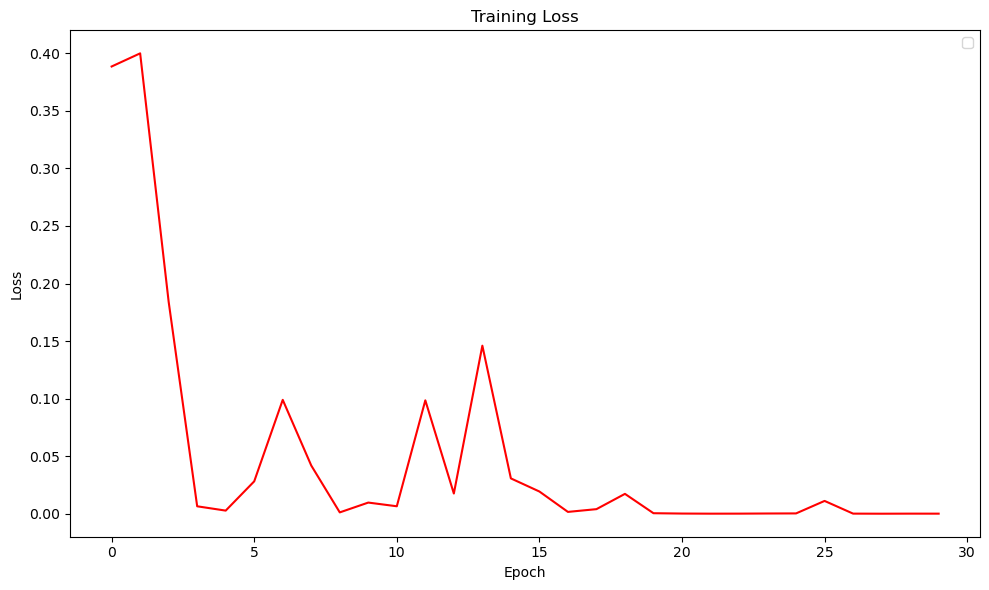

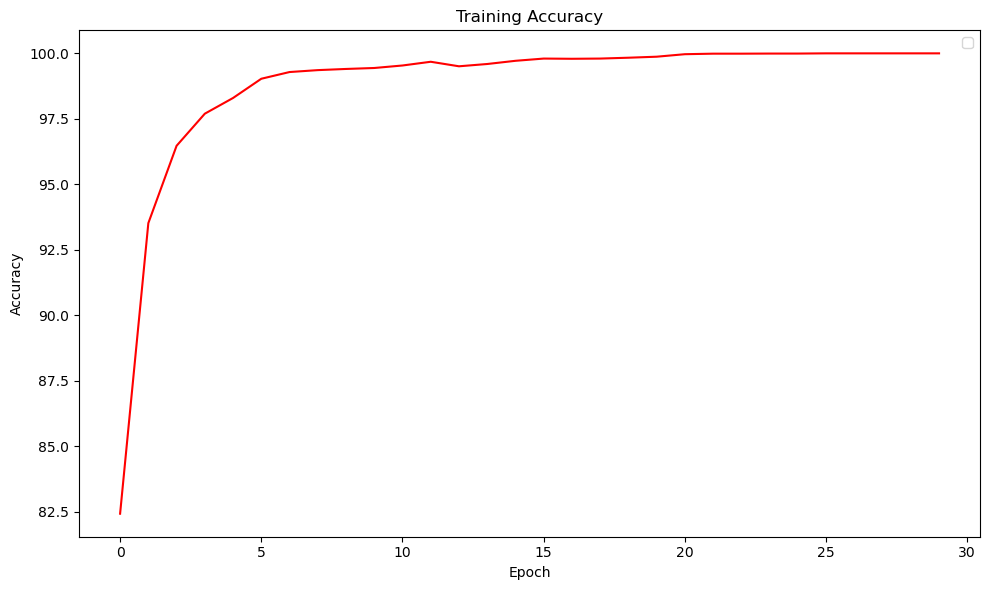

In [11]:
import gc
total_step = len(train_loader)
losses = []
accuracies = []

for epoch in range(num_epochs):
    correct = 0
    total = 0
    
    for i, (images, labels) in enumerate(train_loader):          
        #Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
        
    train_accuracy = 100 * correct / total
    loss = loss.item()
    accuracies.append(train_accuracy)
    losses.append(loss)

    print ('Epoch [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, loss))

    #Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))
        
# Plot
plt.figure(figsize=(10, 6))
plt.plot(losses, color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training Loss")
plt.legend()
plt.tight_layout()
plt.savefig("Training Loss.png")

plt.figure(figsize=(10, 6))
plt.plot(accuracies, color='red')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Training Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("Training Accuracy.png")
plt.show()

In [12]:
preds = []
actual = []

with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            out_labels = torch.argmax(outputs, dim=1)
            preds += out_labels.tolist()
            actual += labels.tolist()
    
            del images, labels, outputs
    
        print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

Accuracy of the network on the 10000 test images: 97.26651480637813 %


<Figure size 2000x1200 with 0 Axes>

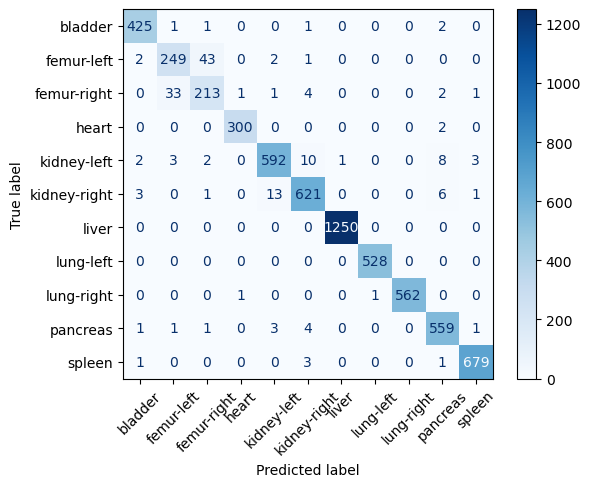

In [13]:
import sklearn.metrics

class_labels = sorted(test_set.dataset.class_lbl.keys())

cm = sklearn.metrics.confusion_matrix(actual, preds)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(20, 12))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

In [14]:
cm_np = np.array(cm)
stats = pd.DataFrame(index=class_labels)
stats['Precision'] = [cm_np[i, i]/np.sum(cm_np[:, i]) for i in range(len(cm_np))]
stats['Recall'] = [cm_np[i, i]/np.sum(cm_np[i, :]) for i in range(len(cm_np))]
stats

,Precision,Recall
bladder,0.979263,0.988372
femur-left,0.867596,0.838384
femur-right,0.816092,0.835294
heart,0.993377,0.993377
kidney-left,0.968903,0.953301
kidney-right,0.964286,0.962791
liver,0.999201,1.000000
lung-left,0.998110,1.000000
lung-right,1.000000,0.996454
pancreas,0.963793,0.980702


In [15]:
preds = pd.Series(preds)
actual = pd.Series(actual)
print(preds)
print(actual)

0       7
1       2
2       5
3       7
4       5
       ..
6141    5
6142    1
6143    6
6144    7
6145    3
Length: 6146, dtype: int64
0       7
1       1
2       5
3       7
4       5
       ..
6141    5
6142    1
6143    6
6144    7
6145    2
Length: 6146, dtype: int64


In [16]:
torch.save(model.state_dict(), os.path.join("model.pth"))

In [17]:
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()

test_dataset = CustomTestDataset('test/', transform)
test_dataset = DataLoader(test_dataset, batch_size=1, shuffle=False)
output_csv = "submission.csv"

In [18]:
results = []
class_idx_to_name = ["bladder", "femur-left", "femur-right", "heart", "kidney-left", "kidney-right", "liver", "lung-left", "lung-right", "pancreas", "spleen"]

with torch.no_grad():
    print(len(test_dataset))
    for i, (images, name) in enumerate(test_dataset):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        name = name[0].split('\\')[-1]
        pred = predicted.item()
        pred_class = class_idx_to_name[pred]
        results.append({'id': name, 'class': pred_class})
        print(name, pred_class)

        del images, outputs
        
# Save to CSV
df = pd.DataFrame(results)
df.to_csv(output_csv, sep=',', index=False)
print(f"Saved predictions to {output_csv}")

46156
a_0.png heart
a_1.png liver
a_10.png liver
a_100.png lung-right
a_1000.png femur-left
a_10000.png pancreas
a_10001.png liver
a_10002.png lung-left
a_10003.png liver
a_10004.png bladder
a_10005.png liver
a_10006.png lung-right
a_10007.png femur-left
a_10008.png lung-left
a_10009.png lung-left
a_1001.png kidney-right
a_10010.png kidney-right
a_10011.png femur-right
a_10012.png pancreas
a_10013.png liver
a_10014.png spleen
a_10015.png femur-left
a_10016.png lung-right
a_10017.png spleen
a_10018.png lung-left
a_10019.png pancreas
a_1002.png kidney-right
a_10020.png lung-left
a_10021.png kidney-right
a_10022.png liver
a_10023.png kidney-left
a_10024.png kidney-right
a_10025.png kidney-right
a_10026.png lung-right
a_10027.png liver
a_10028.png liver
a_10029.png liver
a_1003.png spleen
a_10030.png lung-left
a_10031.png liver
a_10032.png kidney-left
a_10033.png spleen
a_10034.png femur-left
a_10035.png kidney-right
a_10036.png lung-right
a_10037.png femur-left
a_10038.png liver
a_10039.p